# Capstone Project: Track 1 - e-commerce business / marketing setting
Gruppo: Luca Vanzetti, Michele Ragno, Benedetta Pollastrini, Daniele Coroneo
___

Al nostro gruppo di Business Intelligence è stato richiesto di **effettuare una analisi completa sull'andamento dell'attività del business di e-commerce**. 
Nello specifico ci è stato richiesto di concentrare lo studio sui seguenti ambiti: 
- Andamento delle vendite
- Scorte dei prodotti nei magazzini 
- Analisi performance dei prodotti
  
I dati aziendali sono archiviati nel seguente database BigQuery: `bigquery-public-data.thelook_ecommerce`. l'obbiettivo è interrogare ed estrarre il file dati, eseguire eventuali pulizie se necessario, manipolarli, analizzarli e creare una presentazione avvincente dei risultati ottenuti in Tableau, che successivamente andranno consegnati all'azienda.

### Gli strumenti utilizzati
Per effettuare le analisi richieste dal Business abbiamo utilizzato i seguenti strumenti:
<figure>
<img src="data/img/google-big-query.png" width="500">
</figure>

- BigQuery:
  - Estrazione dei dati dal database SQL.
  - Aggregazione di più sorgenti dati.
  - Analisi preliminari sui dati a disposizione.

<figure>
<img src="data/img/logo-del-linguaggio-di-programmazione-python-2.png" width="500">
</figure>

- Python (Jupyter Notebook):
  - Analisi esplorativa.
  - Pulizia dati.
  - Prime rappresentazioni grafiche dei dati.


<figure>
<img src="data/img/Tableau-Logo.png" width="500">
</figure>

- Tableau:
  - Presentazione dei risultati ottenuti.
  - Interattività tramite Dashboard.





### Il diagramma E/R della sorgente dati
Come anticipato precendetemente, la sorgente dati a disposizione era situata sul database aziendale `bigquery-public-data.thelook_ecommerce`, da qui abbiamo costruito lo schema E/R per rappresentare graficamente come le tabelle SQL erano collegate.

<figure>
<img src="data/img/Capstone Project - The Look e-commerce.png" width="900">
</figure>

In [16]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

sns.set(rc={'figure.figsize':(15, 9)})
sns.color_palette("Paired")
sns.set(font_scale=1.5) 

______

## Analisi delle scorte nei magazzini (Michele Ragno)
Dovendo analizzare la sezione relativa alle scorte nei magazzini distribuiti sul territorio, ho così suddiviso i principali obbittivi da portare a termine: 
 - **Quali** categorie e **quanti** prodotti sono disponibili nei vari magazzini.
 - Analizzare la **distribuzione delle scorte** nei magazzini.
 - Verificare eventuali anomalie nel **processo di consegna merci** dei magazzini

### Categorie e Prodotti in stock
Utilizzando la query sottostante, estrapoliamo dalla mole di dati; 
- Tutte le categorie di prodotti presenti nei magazzini.
- Dettagli inerenti alle scorte.
- La quantità di scorte per nome prodotto e quanti ne sono stati venduti.

depositiamo il risultato della query in questo percorso `data/extracted data/product_items_instock.csv`: 

``` mysql
SELECT 
dist_center.id as distribution_center_id,
dist_center.name as distribution_center_name, 
inv_items.product_category,
inv_items.product_name,
inv_items.product_department,
count(inv_items.id) as nums_of_items_in_stock,
count(inv_items.sold_at) as nums_of_sold_items

FROM `bigquery-public-data.thelook_ecommerce.inventory_items` as inv_items
JOIN `bigquery-public-data.thelook_ecommerce.distribution_centers` as dist_center
ON inv_items.product_distribution_center_id = dist_center.id

GROUP BY 
dist_center.name, 
dist_center.id, 
inv_items.product_category,
inv_items.product_department

Order by product_category asc
```



Importiamo l'estrazione con Pandas e verifichiamo che il numero di categorie di prodotti presenti è: 26 categorie univoche per le scorte dei prodotti.

In [17]:
items_instock = pd.read_csv("data/extracted data/product_items_instock.csv")

categories = items_instock[["product_category"]].drop_duplicates(ignore_index=True)
categories

,product_category
0,Accessories
1,Active
2,Blazers & Jackets
3,Clothing Sets
4,Dresses
5,Fashion Hoodies & Sweatshirts
6,Intimates
7,Jeans
8,Jumpsuits & Rompers
9,Leggings


Ora, analizziamo quanti prodotti sono presenti per ciascuna categoria, notiamo subito che la `Intimates` è quella che presenta generalmente più scorte. Mentre le `Clothing Sets` sono presenti scorte in quantità limitata.

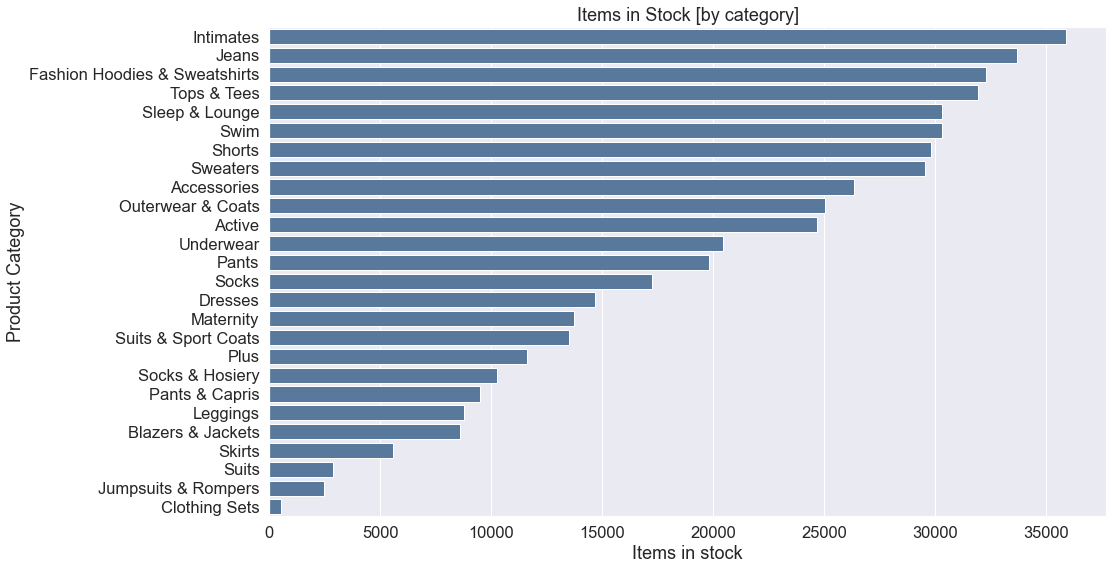

In [22]:
# Unisco le categorie con le scorte e sommo il totale delle scorte per categoria
count_item_cat_instock = categories.merge(items_instock, on="product_category")

count_item_cat_instock = count_item_cat_instock.groupby(["product_category"])['nums_of_items_in_stock'].sum().reset_index()
count_item_cat_instock.sort_values(by="nums_of_items_in_stock", ascending=False, inplace=True)

# Rappresentazione del grafico
sns.barplot(data=count_item_cat_instock, x="nums_of_items_in_stock", y="product_category", color="#4e79a7")
plt.xlabel('Items in stock')
plt.ylabel('Product Category')
plt.title('Items in Stock [by category]')
plt.show()

Inoltre, effettuando una ulteriore analisi sulla suddivisione dei prodotti, la maggior parte di questi sembra concentrata prettamente su prodotti femminili. Nonostante alcune delle categorie, presenti anche sul mercato, siano prodotti unisex.

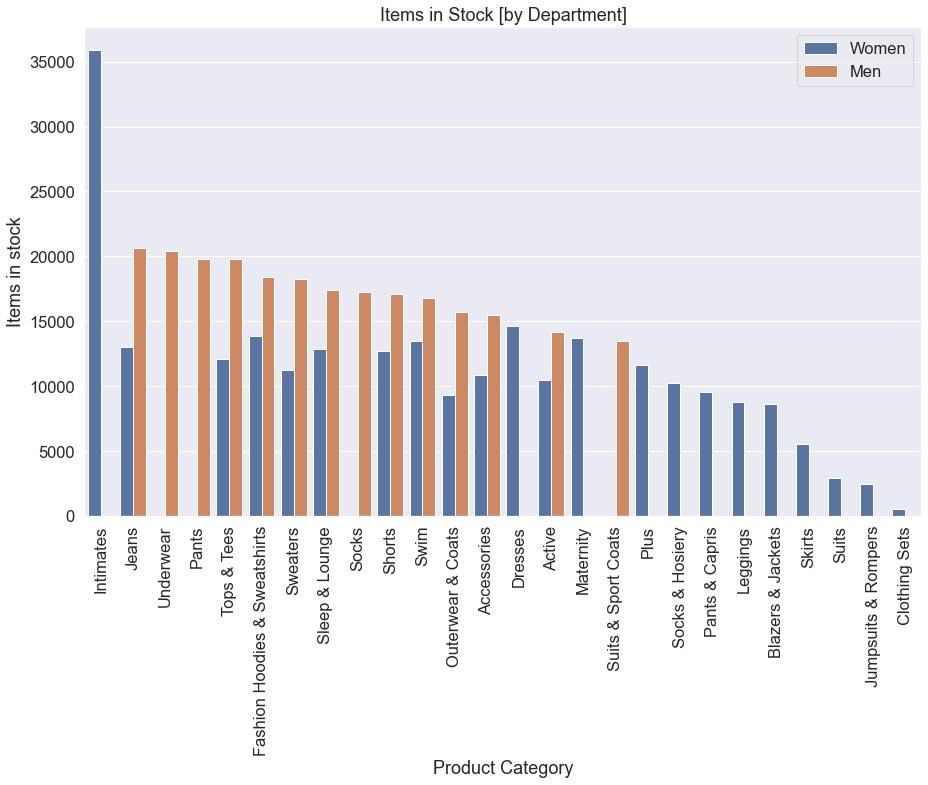

In [27]:
prod_cat_department = categories.merge(items_instock, on="product_category").sort_values(by="nums_of_items_in_stock", ascending=False)
prod_cat_department = prod_cat_department.groupby(["product_category", "product_department"])[["nums_of_items_in_stock"]].sum().reset_index()
prod_cat_depart_sorted = prod_cat_department.sort_values(by="nums_of_items_in_stock", ascending=False)

# Rappresentazione del grafico
sns.barplot(data=prod_cat_depart_sorted, x="product_category", y="nums_of_items_in_stock", hue="product_department")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.xlabel('Product Category')
plt.ylabel('Items in stock')
plt.title('Items in Stock [by Department]')
plt.show()

### Prodotti distribuiti nei magazzini
Analizziamo ora come i prodotti visualizzati precedentemente si distribuiscono tra i vari magazzini. 
Per prima cosa identifichiamo; quali sono i magazzini a nostra disposizione, visualizziamo la situazione generale delle scorte presenti e successivamente come le categorie di prodotti sono suddivisi in essi.

In [28]:
items_per_distr_center = items_instock.groupby(["distribution_center_name"])[["nums_of_items_in_stock"]].sum().reset_index()
print(items_per_distr_center["distribution_center_name"])
items_per_distr_center.sort_values(by="nums_of_items_in_stock", ascending=False, inplace=True)

0                                  Charleston SC
1                                     Chicago IL
2                                     Houston TX
3                                 Los Angeles CA
4                                     Memphis TN
5                                      Mobile AL
6                                 New Orleans LA
7                                Philadelphia PA
8    Port Authority of New York/New Jersey NY/NJ
9                                    Savannah GA
Name: distribution_center_name, dtype: object


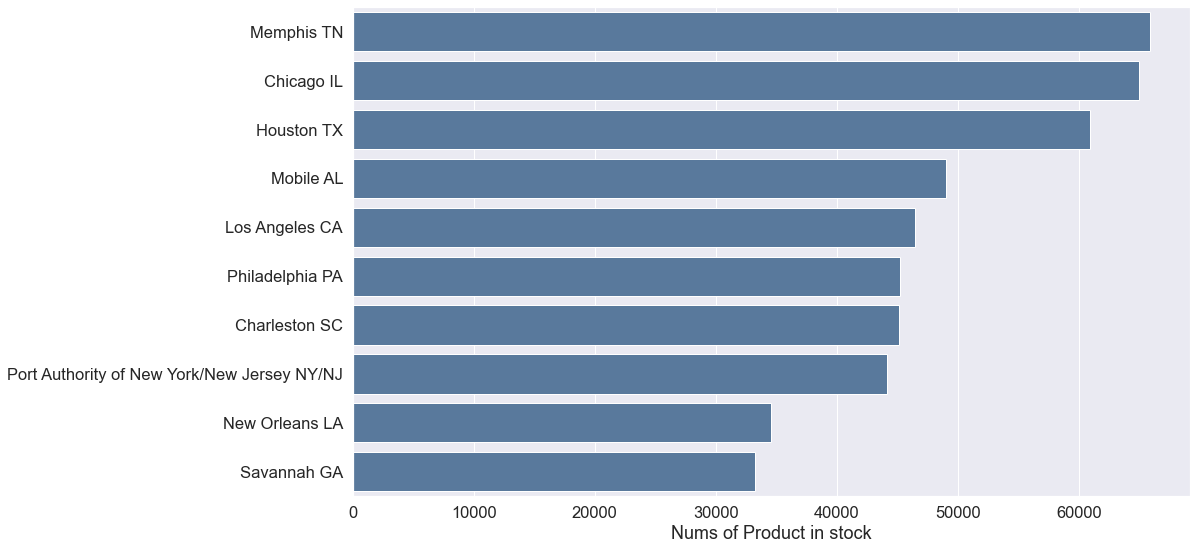

In [29]:
sns.barplot(data=items_per_distr_center, x="nums_of_items_in_stock", y="distribution_center_name", color="#4e79a7")
plt.ylabel(None)
plt.xlabel("Nums of Product in stock")
plt.show()

Di seguito, è riportato una heatmap dove sono riportate le numeriche delle scorte presenti nei magazzini, suddivisi in categorie di prodotti.
Notiamo subito che, le scorte non sono suddivise uniformemente e in alcuni casi ci sono magazzini che non possiedono nessuna scorta come:
 - Mobile AL e New Orleans LA: non possiedono scorte di **Suits & Sport Coats**
 - Philadelphia PA e Savannah GA: non possiedono scorte di **Clothing Sets**
 
Da notare che **Intimates** e **Swim** si concentrano maggiormente in singoli magazzini e che **Savannah GA** e **New Orleans LA** risultano essere quelli meno diversificati in fatto di categorie.

In [40]:
prod_by_distr_center = items_instock.groupby(["distribution_center_name", "product_category"])[["nums_of_items_in_stock"]].sum().reset_index()
prod_by_distr_center = prod_by_distr_center.pivot("product_category", "distribution_center_name", "nums_of_items_in_stock")

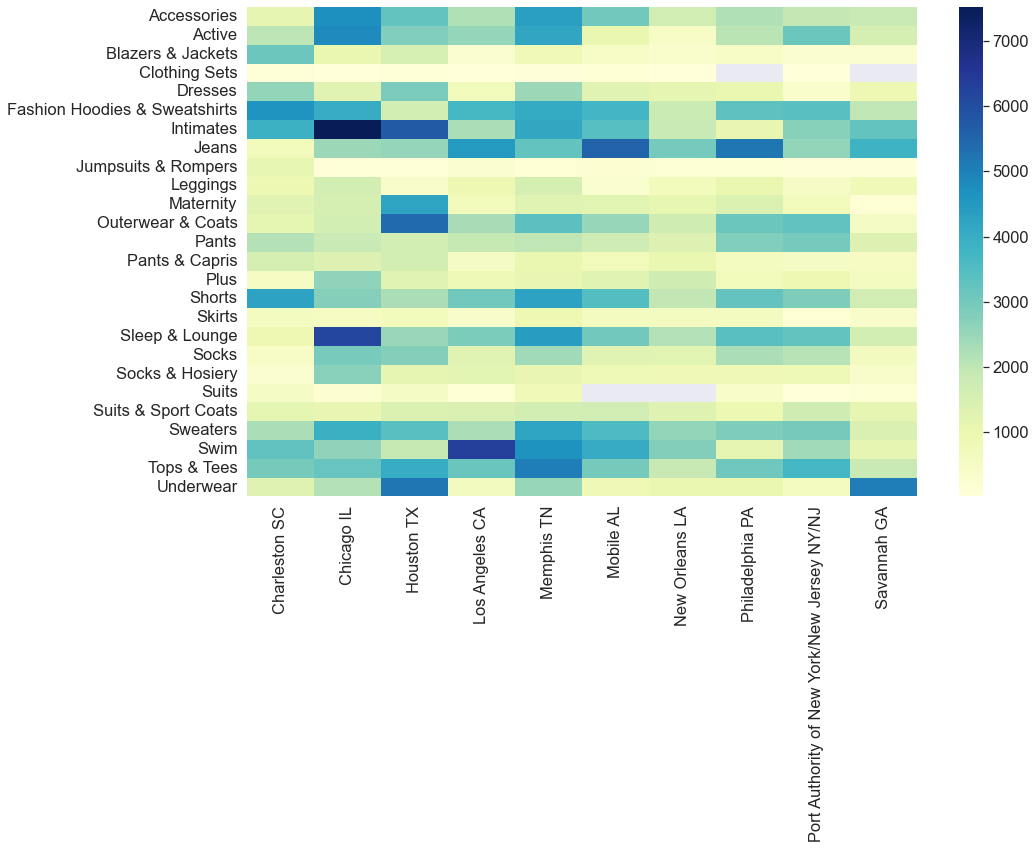

In [41]:
ax = sns.heatmap(prod_by_distr_center, cmap="YlGnBu",)
plt.ylabel(None)
plt.xlabel(None)
plt.show()

Considerando il grafico precedente, dovrebbe poter essere necessaria una ridistribuzione delle merci, tuttavia vanno considerati i vari prodotti venduti per ogni categoria. Pertanto, visualizziamo i prodotti suddivisi per categoria tenendo in considerazione anche le merci vendute.

Questa rappresentazione potrebbe essere utile per poi costruire degli scenari utilizzando una **What-If analisi** (Da implementare su Tableau)

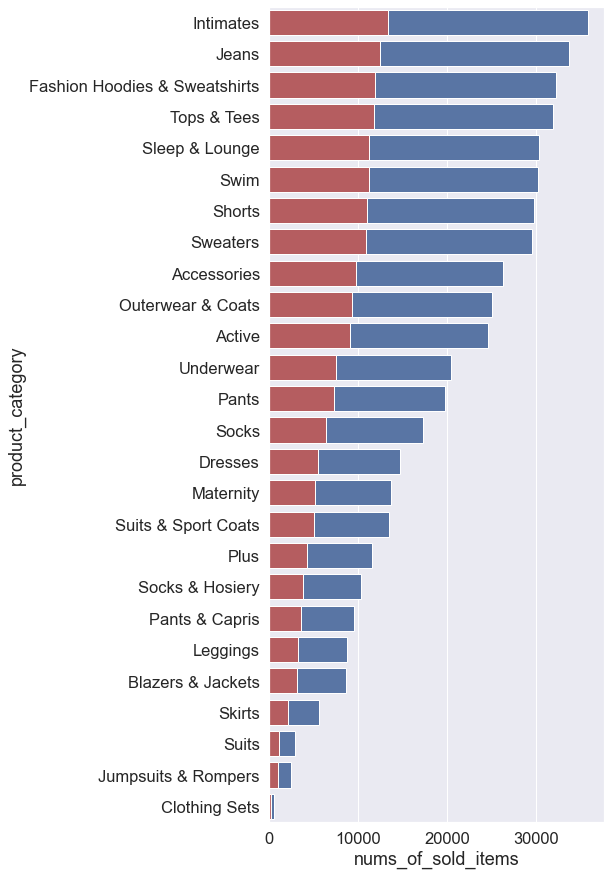

In [44]:
prod_cat_sold = pd.read_csv("data/extracted data/product_items_instock.csv")
grouped_cat_sold = prod_cat_sold.groupby(by="product_category")[["nums_of_items_in_stock","nums_of_sold_items"]].sum().reset_index().sort_values(by="nums_of_items_in_stock", ascending=False)


f, ax = plt.subplots(figsize=(6, 15))

# Barplot BLU del numero totale di item
sns.barplot(x="nums_of_items_in_stock", y="product_category", data=grouped_cat_sold, color="b")

# Barplot ROSSO del numero di item venduti
sns.barplot(x="nums_of_sold_items", y="product_category", data=grouped_cat_sold, color="r")
plt.show()

### Analisi qualità consegne e valore degli utili
Ora che abbiamo analizzato la situazione delle merci in magazzino, ho voluto indagare ulteriormente sugli stati delle consegne (che effettuano i magazzini) e il valore degli utili presenti in ogni fase della consegna.
Tramite la query presente sotto, sono riuscito ad estrarre la differenza di ore impiegate nelle fasi di consegna dei magazzini e ho depositato l'estrazione qui: `data/extracted data/distr_center_performance.csv`: 

``` mysql
SELECT

dist_cent.name as distribution_center_name,
ord_items.status,
count(inv_items.id) as nums_of_items,
ROUND(AVG(DATE_DIFF(ord_items.shipped_at, ord_items.created_at, hour)),2) as hours_created_to_ship,
ROUND(AVG(DATE_DIFF(ord_items.delivered_at, ord_items.shipped_at, hour)),2) as hours_ship_to_deliver,

ROUND(SUM(ord_items.sale_price), 2) as sale_price_amount, 

MIN(ord_items.created_at) as oldest_created_ord_date,
MAX(ord_items.created_at) as newest_created_ord_date

FROM `bigquery-public-data.thelook_ecommerce.order_items` as ord_items 
JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` as inv_items
ON ord_items.inventory_item_id = inv_items.id
JOIN `bigquery-public-data.thelook_ecommerce.distribution_centers` as dist_cent
ON inv_items.product_distribution_center_id = dist_cent.id

GROUP BY 
dist_cent.name,
ord_items.status

```


Importiamo il dataset in Pandas e indaghiamo se ci sono magazzini che riscontrano problemi con le consegne. 

In [54]:
distr_center_data = pd.read_csv("data/extracted data/distr_center_performance.csv")
distr_center_data.sort_values(by="distribution_center_name", ascending=True)
distr_center_data.head()

,distribution_center_name,status,nums_of_items,hours_created_to_ship,hours_ship_to_deliver,sale_price_amount,oldest_created_ord_date,newest_created_ord_date
0,Houston TX,Shipped,6919,12.68,NaN,487476.59,2019-01-14T13:10:39Z,2022-09-29T23:26:20.131Z
1,Houston TX,Cancelled,3433,NaN,NaN,235603.02,2019-02-17T11:46:51Z,2022-09-30T14:56:43.269Z
2,Houston TX,Returned,2228,11.90,58.31,152020.98,2019-02-05T08:20:24Z,2022-09-30T11:48:01Z
3,Houston TX,Complete,5728,12.52,59.58,398158.01,2019-01-12T05:15:51Z,2022-09-30T00:19:48.334Z
4,Houston TX,Processing,4537,NaN,NaN,316900.65,2019-01-23T05:46:39Z,2022-09-30T17:47:24Z


In [59]:
distr_center_data['oldest_created_ord_date'] = pd.to_datetime(distr_center_data['oldest_created_ord_date'])
distr_center_data['oldest_created_ord_date'] = distr_center_data['oldest_created_ord_date'].dt.strftime('%d/%m/%Y - %H:%M')

# Formatto la data
distr_center_data['newest_created_ord_date'] = pd.to_datetime(distr_center_data['newest_created_ord_date'])
distr_center_data['newest_created_ord_date'] = distr_center_data['newest_created_ord_date'].dt.strftime('%d/%m/%Y - %H:%M')
distr_center_data.head()

,distribution_center_name,status,nums_of_items,hours_created_to_ship,hours_ship_to_deliver,sale_price_amount,oldest_created_ord_date,newest_created_ord_date
0,Houston TX,Shipped,6919,12.68,NaN,487476.59,14/01/2019 - 13:10,29/09/2022 - 23:26
32,Memphis TN,Shipped,7424,12.68,NaN,431854.64,14/01/2019 - 09:49,30/09/2022 - 15:56
3,Houston TX,Complete,5728,12.52,59.58,398158.01,01/12/2019 - 05:15,30/09/2022 - 00:19
37,Chicago IL,Shipped,7145,11.81,NaN,397806.16,18/01/2019 - 07:23,30/09/2022 - 11:44
5,Mobile AL,Shipped,5459,12.91,NaN,364916.33,20/01/2019 - 07:56,30/09/2022 - 15:57


Plottando il grafico, sembra che la maggior parte dello stato delle consegne sia in stato **Shipped**, da sottolineare il fatto che sono presenti più consegne in Shipped che in Complete.  

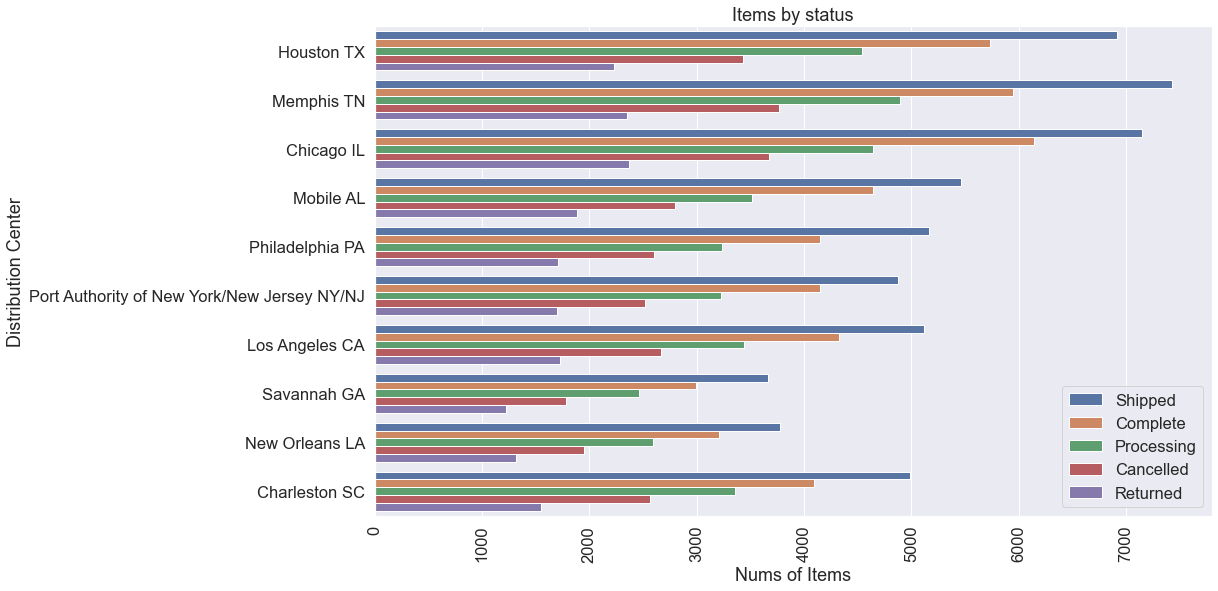

In [63]:
# Rappresentazione del grafico
sns.barplot(data=distr_center_data, x="nums_of_items", y="distribution_center_name", hue="status")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.xlabel('Nums of Items')
plt.ylabel('Distribution Center')
plt.title('Items by status')
plt.show()

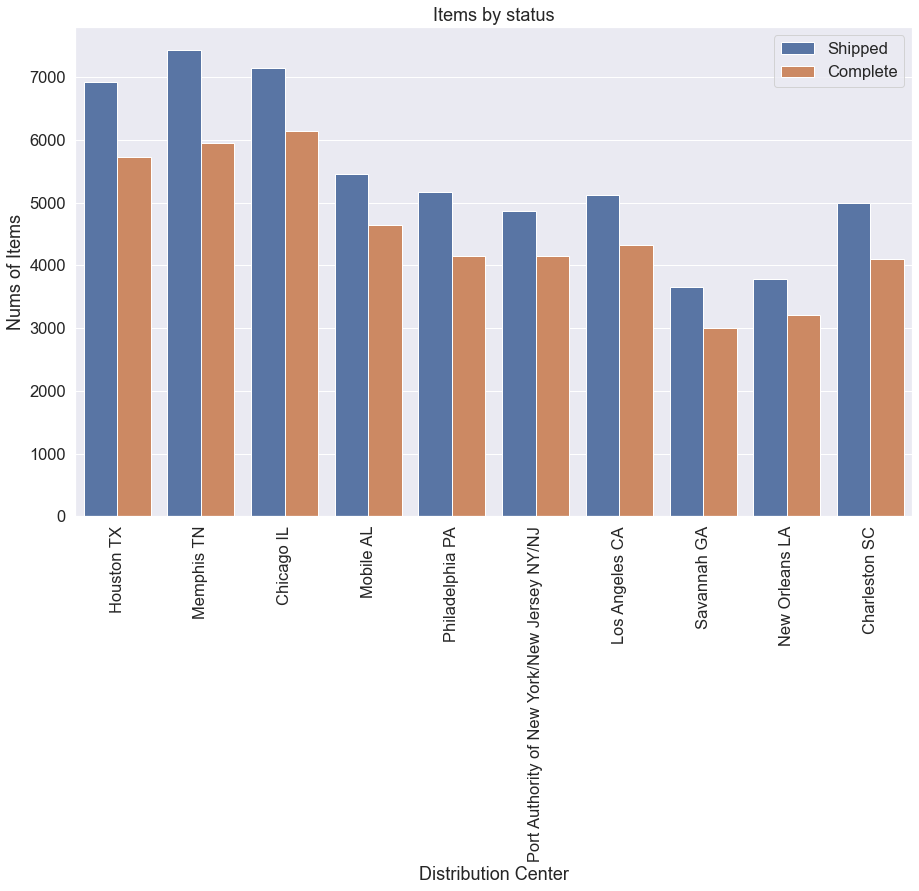

In [66]:
processing_performance = distr_center_data[(distr_center_data["status"] == "Shipped") | (distr_center_data["status"] == "Complete")]
processing_performance.sort_values(by="distribution_center_name", ascending=True)

# Rappresentazione del grafico
sns.barplot(data=processing_performance, x="distribution_center_name", y="nums_of_items", hue="status")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.xlabel('Distribution Center')
plt.ylabel('Nums of Items')
plt.title('Items by status')
plt.show()